# Segmenting interlayers

Welcome! 
In this tutorial we train a neural network to segment interlayers on seismic cube `P_cube`

In [1]:
import sys
import os

In [2]:
sys.path.append('../repos/seismiqb/')

In [3]:
import numpy as np
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


## Preparations: working with `Dataset` of cubes and horizon-labels

* Indexing seismic cubes: setting up `SeismicCubeset`

In [4]:
from seismiqb import SeismicCropBatch, SeismicCubeset
from seismiqb.batchflow import FilesIndex, D, L, F, Pipeline, B, V

In [5]:
DATA_DIR = '/notebooks/data/cubes/CUBE_3/'

In [6]:
qbix = FilesIndex(path=os.path.join(DATA_DIR, 'P_cube.sgy'), no_ext=True)
qbset = SeismicCubeset(qbix)

* load info about seismic cubes into `SeismicCubeset`

In [7]:
qbset.load_geometries()

Working with CUBE_3/P_cube.sgy: 100%|██████████| 7113463/7113463 [01:18<00:00, 90898.76it/s]


* load horizon-labels

In [8]:
pref = os.path.join(DATA_DIR, 'HORIZONTS')
horizons_paths = [os.path.join(pref, p) for p in ['prb_B_anon.txt',
                                                  'prb_T_ALL_anon.txt',
                                                  'prb_G_anon.txt',
                                                  'prb_M_anon.txt']]

In [9]:
qbset.load_point_clouds(paths={qbset.indices[0]: horizons_paths})

In [10]:
qbset.load_labels()

* make train/test samplers

In [11]:
qbset.load_samplers()

In [12]:
qbset.train_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                            high=[1, 0.3, 1]).sample
qbset.test_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                           low=[0, 0.65, 0]).sample

* `pipeline` for loading cube crops and building segmentation-masks

In [13]:
wflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('train_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

In [14]:
pset = (qbset >> wflow)

* example of a crop and its mask

Text(0.5, 1.0, 'Interlayers')

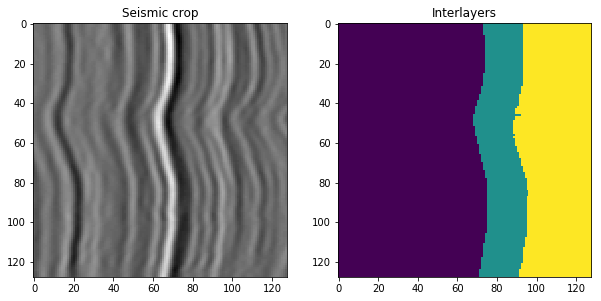

In [15]:
import matplotlib.pyplot as plt
b = pset.next_batch(1, n_epochs=None)
figs, axes = plt.subplots(1, 2, figsize=(2 * 5, 5))
axes[0].imshow(b.cubes[0, :, :, 0], cmap=plt.cm.gray)
axes[1].imshow(b.masks[0, :, :])
axes[0].set_title('Seismic crop')
axes[1].set_title('Interlayers')

## Training `UNet` for segmenting interlayers

In [25]:
from seismiqb.batchflow.models.tf import UNet
from tqdm import trange
from IPython.display import clear_output

* configuring `unet`

In [26]:
config = {'inputs': dict(cubes={'shape': (128, 128, 1)},
                         masks={'name': 'targets', 'shape': (128, 128),
                                'classes': 10, 'transform': 'ohe'}),
          'initial_block/inputs': 'cubes',
          'loss': 'dice',
          'head': dict(num_classes=10),
          'optimizer': 'Adam'}

* add model-training actions to preprocessing pipeline:

In [27]:
trainflow = wflow + (Pipeline()
                     .init_variable('loss', default=list())
                     .init_model('static', UNet, 'model', config)
                     .train_model('model', feed_dict={'cubes': B('cubes'),
                                  'masks': B('masks')},
                                  fetches='loss', save_to=V('loss'), mode='a'))

* train the model

In [28]:
pset = (qbset >> trainflow)

In [ ]:
N_ITERS = 300
tr = trange(N_ITERS, leave=True)
for i in tr:
    pset.next_batch(1, n_epochs=None)
    tr.set_description("current loss is {}".format(pset.get_variable('loss')[-1]))
    clear_output()

current loss is -0.02055404521524906:  12%|█▏        | 37/300 [02:01<14:01,  3.20s/it]

* check out the results on crops from test-part of the cube

In [33]:
tflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('test_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

In [34]:
test_batch = (qbset >> tflow).next_batch(1)

In [39]:
import tensorflow as tf

In [40]:
def get_lines_range(batch, item):
    g = batch.get(batch.indices[item], 'geometries')
    ir = (g.ilines[np.min(batch.slices[item][0])],
          g.ilines[np.max(batch.slices[item][0])])
    ir = (np.array(ir) - g.ilines[0]) / (g.ilines[-1] - g.ilines[0])
    
    xr = (g.xlines[np.min(batch.slices[item][1])],
          g.xlines[np.max(batch.slices[item][1])])
    xr = (np.array(xr) - g.xlines[0]) / (g.xlines[-1] - g.xlines[0])
    return ir, xr

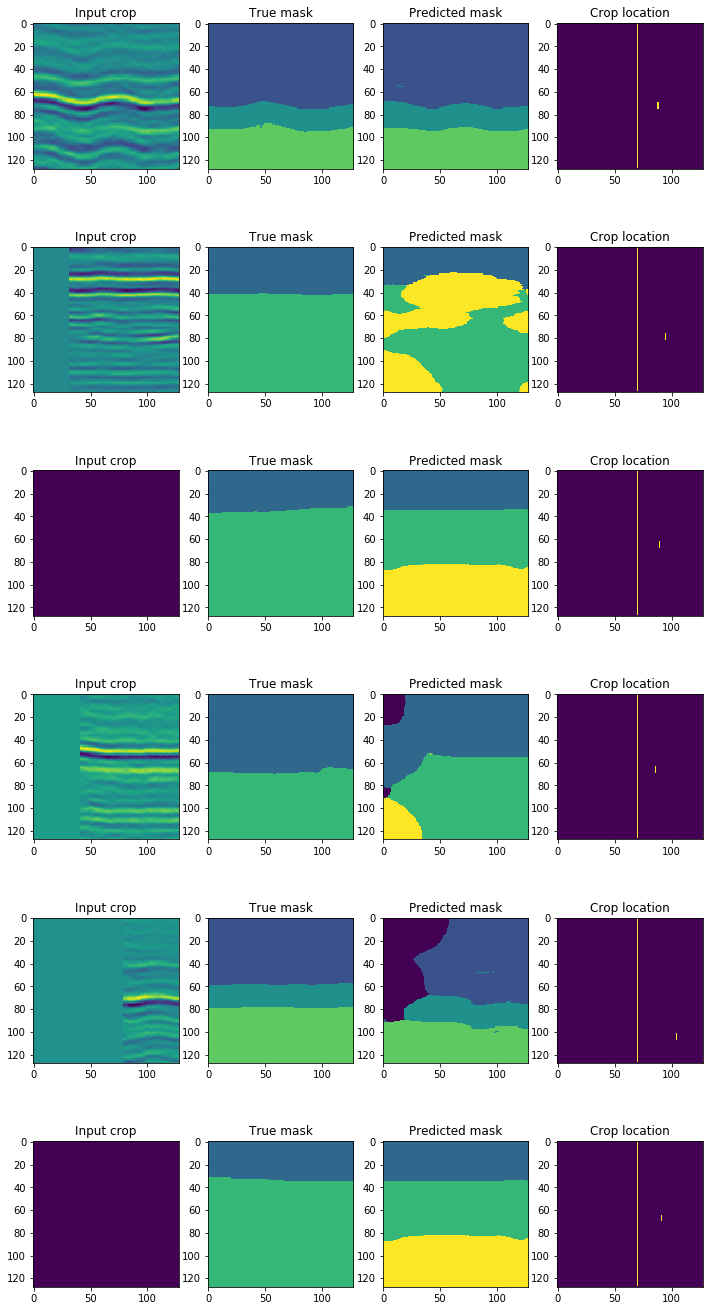

In [47]:
unet = pset.get_model_by_name('model')
targets, predictions = unet.predict(fetches=['targets', tf.nn.softmax(unet.predictions)],
                                    feed_dict={unet.cubes: test_batch.cubes, unet.masks: b.masks})
n_rows = 6
figs, axes = plt.subplots(n_rows, 4, figsize=(3 * 4, n_rows * 4))
for i, nr in enumerate([0, 8, 12, 13, 31, 28]):
    vmin, vmax = np.min(targets.argmax(axis=-1)[nr,...]) - 1, np.max(targets.argmax(axis=-1)[nr,...]) + 1
    axes[i, 0].imshow(test_batch.cubes[nr,...,0].T)
    axes[i, 1].imshow(targets.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)
    axes[i, 2].imshow(predictions.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)

    axes[i, 0].set_title('Input crop')
    axes[i, 1].set_title('True mask')
    axes[i, 2].set_title('Predicted mask')
    axes[i, 3].set_title('Crop location')
    
    ir, xr = get_lines_range(test_batch, nr)
    ir = np.round([128 * ir[0], 128 * ir[1]]).astype(np.int32)
    xr = np.round([128 * xr[0], 128 * xr[1]]).astype(np.int32)
    locs = np.zeros((128, 128), dtype=np.float64)
    locs[ir[0]:ir[1], xr[0]:xr[1] + 1] = 1
    locs[0:-1, np.int(0.55 * 128)] = 1
    axes[i, 3].imshow(locs)